In [13]:
# !pip install dbfread
# !pip install rasterio
# !pip install scipy

In [329]:
# !pip install dbfread
import glob
from dbfread import DBF
import pandas as pd
import os

"""
Read DBF files from local storage, filter crop classes, and store them in cleaned_dataframes.
"""

# Define the file pattern to search for DBF files in the specified directory
file_pattern = os.path.join(
    "drive/MyDrive/Datathon/HDSI_AGRI_Prompt_1/cropland_images/*/", "*.tif.vat.dbf"
)  # Change to your path
matching_files = glob.glob(file_pattern)  # Get all matching file paths

# List of terms to exclude when filtering crop classes
exclude_terms = [
    "Undefined",
    "Barren",
    "land",
    "Developed",
    "Clouds/No Data",
    "Background",
    "Snow",
    "Open Water",
    "Water",
    "Forest",
    "Aquaculture",
]  # Should add more terms as necessary

# Dictionary to store cleaned DataFrames
cleaned_dataframes = {}

# Iterate through each matching DBF file
for dbf_file in matching_files:
    # Open the DBF file using dbfread
    table = DBF(dbf_file)

    new_records = []  # List to hold records that meet the criteria
    for record in table:
        class_name = record[
            "CLASS_NAME"
        ].strip()  # Remove leading and trailing whitespace
        # Check if CLASS_NAME is not empty and does not contain any excluded terms
        if class_name != "" and not any(term in class_name for term in exclude_terms):
            new_records.append(record)  # Add the record if it meets the criteria

    # Convert the new records list to a Pandas DataFrame
    cleaned_df = pd.DataFrame(new_records)
    # Store the cleaned DataFrame in the dictionary with a combined key
    cleaned_dataframes["_".join(dbf_file.split("\\")[-2:])] = cleaned_df

# Prepare a list to allow DBF files to be searched by county and year
l = []
for key in cleaned_dataframes.keys():
    k = key.split("_")  # Split the key to extract county and year
    county = k[0]  # Extract county from the key
    year = k[2]  # Extract year from the key
    l.append([key, county, year])  # Append the key, county, and year to the list

# Create a DataFrame from the list, setting appropriate column names
dbf_df = pd.DataFrame(l)
dbf_df.columns = ["file_name", "county", "year"]

In [73]:
dbf_df.head()

,file_name,county,year
0,Adams_CDL_2006_53001.tif.vat.dbf,Adams,2006
1,Adams_CDL_2007_53001.tif.vat.dbf,Adams,2007
2,Adams_CDL_2010_53001.tif.vat.dbf,Adams,2010
3,Adams_CDL_2011_53001.tif.vat.dbf,Adams,2011
4,Adams_CDL_2012_53001.tif.vat.dbf,Adams,2012


In [313]:
#!pip install rasterio
#!pip install scipy
import glob
import re
import matplotlib.pyplot as plt
import rasterio
import numpy as np
import os
from concurrent.futures import ThreadPoolExecutor

county = "Idaho"
file_pattern = os.path.join(
    f"drive/MyDrive/Datathon/HDSI_AGRI_Prompt_1/cropland_images/{county}", "*.tif"
)
matching_files = glob.glob(file_pattern)
cropland_dfs = {}


def filter_cropland(cropland_tif):

    # extract the year value of cropland images
    year_pattern = r"20\d{2}"
    match = re.search(year_pattern, cropland_tif)
    if match:
        year = match.group()
    # get the crop values in the dbf file of a certern county and year.
    dbf = dbf_df.loc[
        (dbf_df["county"] == county) & (dbf_df["year"] == year), "file_name"
    ].values[0]
    crop_value = cleaned_dataframes[dbf]["VALUE"]
    # read cropland value from tif and filter by crop_value
    with rasterio.open(cropland_tif) as src:
        tif = src.read(1)
        tif = pd.DataFrame(tif)
        corpland = pd.DataFrame(index=tif.index, columns=tif.columns)
        for col in tif.columns:
            corpland[col] = np.where(tif[col].isin(crop_value), tif[col], 0)
        return f"{county}_{year}", corpland  # filtered cropland of county of that year


from concurrent.futures import ProcessPoolExecutor

# # Use ProcessPoolExecutor to parallelize the operation
with ThreadPoolExecutor() as executor:
    results = executor.map(filter_cropland, matching_files)

results = map(filter_cropland, matching_files)
type(results)
# Store the results in a dictionary
for county_year, corpland in results:
    cropland_dfs[county_year] = corpland

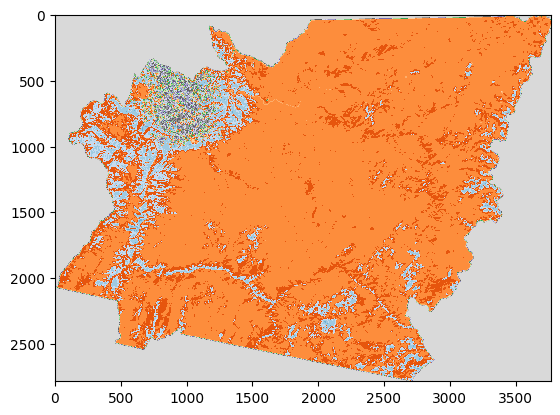

In [314]:
# before filter
with rasterio.open(matching_files[0]) as src:
    tif = src.read(1)
plt.imshow(tif, cmap="tab20c_r")

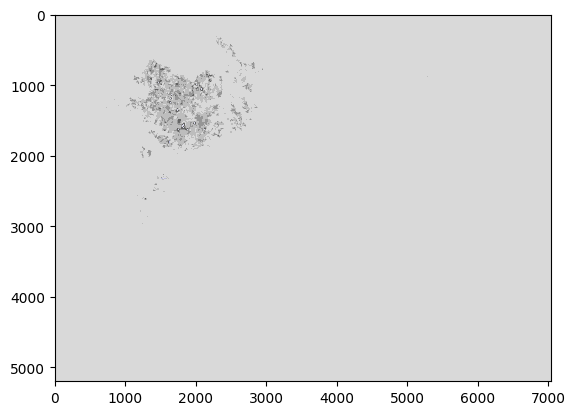

In [315]:
# after filter cropland
plt.imshow(corpland, cmap="tab20c_r")

In [316]:
# Function to convert week number to month
def week_to_month(week):
    if week in range(1, 5):
        return "January"
    elif week in range(5, 9):
        return "February"
    elif week in range(9, 14):
        return "March"
    elif week in range(14, 18):
        return "April"
    elif week in range(18, 23):
        return "May"
    elif week in range(23, 27):
        return "June"
    elif week in range(27, 32):
        return "July"
    elif week in range(32, 36):
        return "August"
    elif week in range(36, 41):
        return "September"
    elif week in range(41, 46):
        return "October"
    elif week in range(46, 50):
        return "November"
    else:
        return "December"

In [317]:
from scipy.ndimage import zoom
import pandas as pd
import glob
import os
import re
import numpy as np
from concurrent.futures import ProcessPoolExecutor
import rasterio

# Define the county and file pattern
file_pattern = os.path.join(
    "drive/MyDrive/Datathon/HDSI_AGRI_Prompt_1/NDVI_images/", f"{county}*.tif"
)
matching_files = glob.glob(file_pattern)


def get_cropland_ndvi(ndvi_file):
    filename = os.path.basename(ndvi_file)
    year_pattern = r"20\d{2}"
    match = re.search(year_pattern, ndvi_file)
    if match:
        year = match.group()  # Extract year from the file name
    else:
        return county, None, None, None  # Handle missing year case

    try:
        cropland = cropland_dfs[
            f"{county}_{year}"
        ]  # Query cropland data from cropland_dfs

    except KeyError:
        # If the specific year does not exist in the cropland image, replace it with the mean of the closest 2 years
        years = [int(key.split("_")[1]) for key in cropland_dfs.keys()]
        closest_years = sorted(years, key=lambda y: abs(y - int(year)))[:2]

        year1 = cropland_dfs[f"{county}_{closest_years[0]}"]
        year2 = cropland_dfs[f"{county}_{closest_years[1]}"]

        # Resize the cropland image of 2 closest years to the same shape
        if year1.shape != year2.shape:
            scale_factor_height = year1.shape[0] / year2.shape[0]
            scale_factor_width = year1.shape[1] / year2.shape[1]
            year2 = zoom(year2, (scale_factor_height, scale_factor_width), order=0)
        cropland = (year1 + year2) / 2

    # The resolution of cropland and NDVI are different, use zoom to make them the same
    with rasterio.open(ndvi_file) as src:
        ndvi = src.read(1)
        scale_factor_height = ndvi.shape[0] / cropland.shape[0]
        scale_factor_width = ndvi.shape[1] / cropland.shape[1]
        cropland_resized = zoom(
            cropland, (scale_factor_height, scale_factor_width), order=0
        )  # Nearest-neighbor interpolation
        masked_ndvi = np.where(
            cropland_resized == 0, np.nan, ndvi
        )  # Replace masked regions with NaN
        masked_ndvi = pd.DataFrame(masked_ndvi).map(
            lambda x: (x - 125) / 125
        )  # Scale NDVI to 0-1

    # Extract week number from the filename
    week = int(filename.split("_")[-2])

    month = week_to_month(week)  # Convert week number to month

    return county, year, month, masked_ndvi


# Initialize an empty list to store results
cropland_ndvis = []

# Run the job in parallel using all available CPUs
# with ProcessPoolExecutor() as executor:
results = map(get_cropland_ndvi, matching_files)

# Store the results in a list
for county, year, month, masked_ndvi in results:
    if masked_ndvi is not None:  # Only add if masked_ndvi is not None
        cropland_ndvis.append([county, year, month, masked_ndvi])

# Create DataFrame
cropland_ndvi_dfs = pd.DataFrame(
    cropland_ndvis, columns=["county", "year", "month", "ndvi"]
)

# Calculate mean NDVI for each county, year, and month
cropland_ndvi_dfs["ndvi_mean"] = cropland_ndvi_dfs["ndvi"].apply(
    lambda df: df.mean().mean(skipna=True)
)

In [325]:
# Group by 'year' and 'month', and calculate the mean of 'ndvi_mean'
cropland_ndvi_aggregated = cropland_ndvi_dfs.groupby(["year", "month"], as_index=False)[
    "ndvi_mean"
].mean()

# Define the order of months
month_order = [
    "January",
    "February",
    "March",
    "April",
    "May",
    "June",
    "July",
    "August",
    "September",
    "October",
    "November",
    "December",
]

# Sort by 'year' in ascending order (this line is currently commented out)
# cropland_ndvi_aggregated = cropland_ndvi_aggregated.sort_values("year")

# Convert the 'month' column to a categorical type and sort it by the custom order
cropland_ndvi_aggregated["month"] = pd.Categorical(
    cropland_ndvi_aggregated["month"], categories=month_order, ordered=True
)

# Sort again based on 'year' and 'month'
cropland_ndvi_aggregated = cropland_ndvi_aggregated.sort_values(["year", "month"])

# Display the results
cropland_ndvi_aggregated

,year,month,ndvi_mean
4,2001,January,0.079708
3,2001,February,0.058142
7,2001,March,0.229818
0,2001,April,0.444320
8,2001,May,0.648846
...,...,...,...
145,2023,August,0.461257
155,2023,September,0.478778
154,2023,October,0.514388
153,2023,November,0.427602


In [319]:
cropland_ndvi_aggregated.head()

,year,month,ndvi_mean
4,2001,January,0.079708
3,2001,February,0.058142
7,2001,March,0.229818
0,2001,April,0.444320
8,2001,May,0.648846


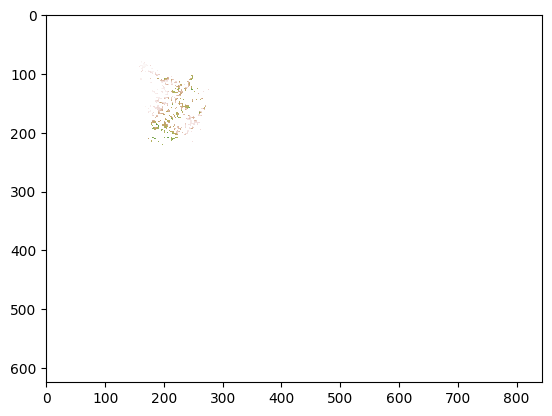

In [320]:
plt.imshow(cropland_ndvi_dfs.iloc[0, 3], cmap=plt.cm.gist_earth_r)

In [326]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np

# Prepare the data: select 'year', 'month', and 'ndvi_mean' columns, and drop any missing values
df = cropland_ndvi_aggregated[["year", "month", "ndvi_mean"]].dropna()

# Map month names to numerical values
month_mapping = {
    "January": 1,
    "February": 2,
    "March": 3,
    "April": 4,
    "May": 5,
    "June": 6,
    "July": 7,
    "August": 8,
    "September": 9,
    "October": 10,
    "November": 11,
    "December": 12,
}
# Create a new column 'month_num' by mapping month names to their corresponding numbers
df["month_num"] = df["month"].map(month_mapping)

# Attempt to convert 'year' column to numeric; invalid values will become NaN
df["year"] = pd.to_numeric(df["year"], errors="coerce")

# Split the data into training (2001 to 2022) and testing (2023) datasets
train_data = df[df["year"] < 2023]
test_data = df[df["year"] == 2023]

# Define features: 'month_num' and target: 'ndvi_mean'
X_train = train_data[["month_num"]].values

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Initialize KMeans clustering with 6 clusters
kmeans = KMeans(n_clusters=6, random_state=42)
# Fit the model and assign each data point to a cluster
train_data["cluster"] = kmeans.fit_predict(X_train_scaled)

# Create a DataFrame for each month of 2023 with numerical month values
months_2023 = pd.DataFrame({"month_num": range(1, 13)})  # Months 1 to 12
# Scale the 2023 months using the previously fitted scaler
months_2023_scaled = scaler.transform(months_2023)

# Predict clusters for the 2023 monthly data
predicted_clusters = kmeans.predict(months_2023_scaled)

# Add the predicted cluster assignments to the months_2023 DataFrame
months_2023["cluster"] = predicted_clusters

# Calculate the mean NDVI for each cluster (for prediction purposes)
ndvi_means_by_cluster = train_data.groupby("cluster")["ndvi_mean"].mean().reset_index()
ndvi_means_by_cluster.columns = [
    "cluster",
    "predicted_ndvi_mean",
]  # Rename to 'predicted_ndvi_mean'

# Merge the NDVI means into the 2023 monthly data based on the cluster
predicted_results = months_2023.merge(ndvi_means_by_cluster, on="cluster", how="left")

# Display the predicted results for 2023
print(predicted_results[["month_num", "predicted_ndvi_mean"]])

    month_num  predicted_ndvi_mean
0           1             0.183656
1           2             0.183656
2           3             0.356646
3           4             0.356646
4           5             0.648892
5           6             0.648892
6           7             0.603913
7           8             0.388908
8           9             0.388908
9          10             0.388908
10         11             0.178010
11         12             0.178010


C:\Users\31234\AppData\Local\Temp\ipykernel_27560\388894302.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data["cluster"] = kmeans.fit_predict(X_train_scaled)
C:\Users\31234\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


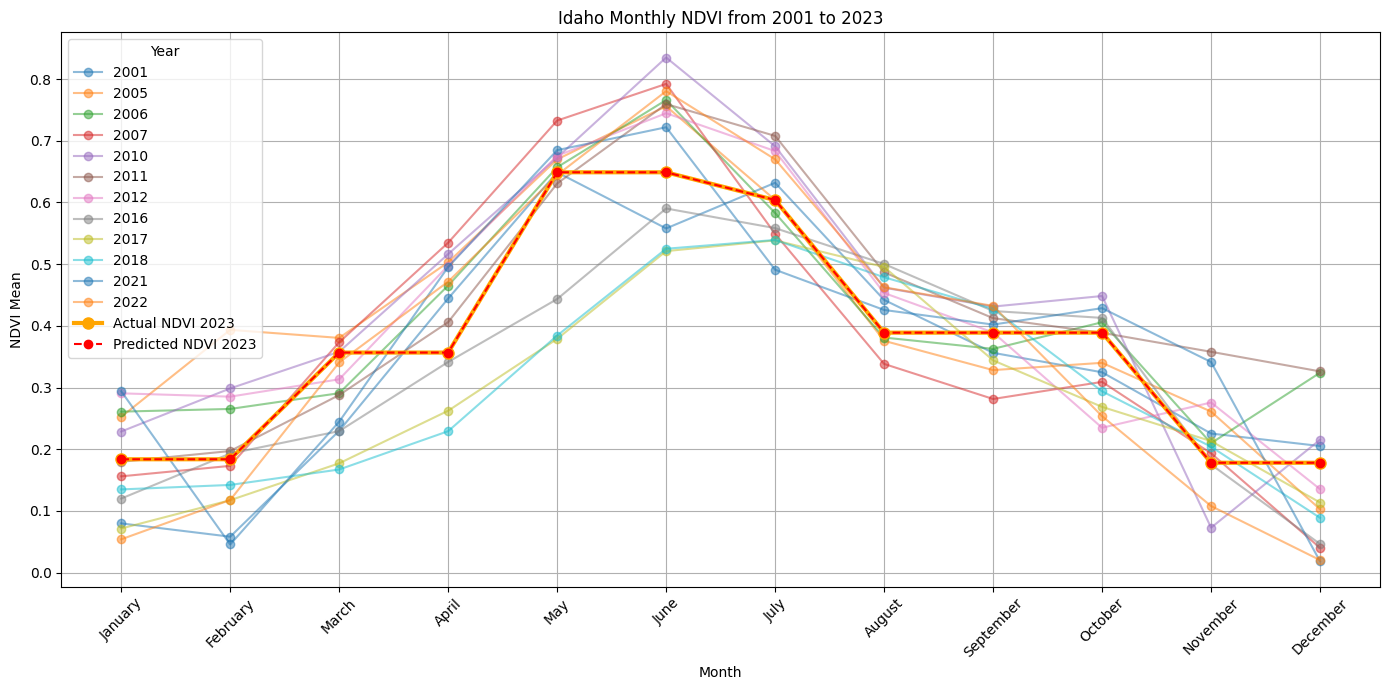

In [327]:
import pandas as pd
import matplotlib.pyplot as plt

# Prepare the data: select 'year', 'month', and 'ndvi_mean' columns, and drop any missing values
df = cropland_ndvi_aggregated[["year", "month", "ndvi_mean"]].dropna()

# Map month names to numerical values
month_mapping = {
    "January": 1,
    "February": 2,
    "March": 3,
    "April": 4,
    "May": 5,
    "June": 6,
    "July": 7,
    "August": 8,
    "September": 9,
    "October": 10,
    "November": 11,
    "December": 12,
}
# Create a new column 'month_num' by mapping month names to their corresponding numbers
df["month_num"] = df["month"].map(month_mapping)

# Attempt to convert 'year' column to numeric; invalid values will become NaN
df["year"] = pd.to_numeric(df["year"], errors="coerce")

# Filter the data to include only records from the year 2001 to 2023
df_filtered = df[(df["year"] >= 2001) & (df["year"] <= 2023)]

# Get the predicted NDVI data and rename the column for consistency
predicted_results = predicted_results.rename(
    columns={"predicted_ndvi_mean": "ndvi_mean"}
)
# Add the year for predicted data (2023)
predicted_results["year"] = 2023
# Map month numbers back to month names for the predicted results
predicted_results["month"] = predicted_results["month_num"].map(
    lambda x: list(month_mapping.keys())[x - 1]
)  # Map back to month names

# Create a new figure for plotting
plt.figure(figsize=(14, 7))

# Define the years to plot actual NDVI data
actual_years = [
    2001,
    2005,
    2006,
    2007,
    2010,
    2011,
    2012,
    2016,
    2017,
    2018,
    2021,
    2022,
]
# Plot historical NDVI data for each specified year
for year in actual_years:
    monthly_data = df_filtered[df_filtered["year"] == year]
    plt.plot(
        monthly_data["month_num"],
        monthly_data["ndvi_mean"],
        marker="o",
        label=str(year),
        alpha=0.5,  # Increase transparency
    )

# Plot actual NDVI data for 2023 with a more distinctive color and thicker lines
plt.plot(
    predicted_results["month_num"],
    predicted_results["ndvi_mean"],
    marker="o",
    color="orange",  # Use a more noticeable color
    linestyle="-",  # Solid line
    linewidth=3,  # Thicker line
    markersize=8,  # Increase marker size
    label="Actual NDVI 2023",  # Update the legend name
)

# Plot predicted NDVI data for 2023
plt.plot(
    predicted_results["month_num"],
    predicted_results["ndvi_mean"],
    marker="o",
    color="red",
    linestyle="--",  # Dashed line
    label="Predicted NDVI 2023",
)

# Set chart properties
plt.title("Idaho Monthly NDVI from 2001 to 2023")
plt.xlabel("Month")
plt.ylabel("NDVI Mean")
# Replace X-axis numbers with month names and rotate for better readability
plt.xticks(range(1, 13), list(month_mapping.keys()), rotation=45)
plt.legend(title="Year")  # Add legend title
plt.grid()  # Add grid lines
plt.tight_layout()  # Adjust layout to fit labels

# Display the chart
plt.show()

In [323]:
import pandas as pd
from sklearn.metrics import mean_squared_error

# Assuming predicted_results contains the predicted data for the year 2023
# Ensure that actual_ndvi_values is a list or array containing the actual NDVI values for each month of 2023

# Retrieve the predicted NDVI values for 2023
predicted_ndvi_2023 = predicted_results["ndvi_mean"].values
# Retrieve the actual NDVI values for 2023 (ensure this data corresponds to the correct months)
# Here we assume you have a DataFrame df that contains the actual NDVI data
actual_ndvi_2023 = df_filtered[df_filtered["year"] == 2023]["ndvi_mean"].values

# Calculate Mean Squared Error (MSE) between actual and predicted values
mse = round(mean_squared_error(actual_ndvi_2023, predicted_ndvi_2023), 6)

# Output the MSE result
print(f"Mean Squared Error for 2023 predictions: {mse}")

Mean Squared Error for 2023 predictions: 0.012973
